<center>


# ARHITEKTURA NEURONSKIH MREŽA
## 2023./2024.
## Projekt - Analiza hiperparametara
#### Marko Bonovil
#### 2. dio
</center>


#Biblioteke

In [ ]:
import os
import math
import time
import pickle
import numpy as np
import pandas as pd
from math import exp
import seaborn as sns
import tensorflow as tf
from keras import losses
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras import initializers, optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adagrad, Adam, RMSprop, SGD
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [ ]:
!pip install keras-tuner
from keras_tuner import Hyperband, HyperParameters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


#Učitavanje skupa podataka

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Arhitekture neuronskih mreža/Projekt

/content/drive/MyDrive/Arhitekture neuronskih mreža/Projekt


In [ ]:
X_train_undersampling=pd.read_csv("X_train_undersampling.csv")
y_train_undersampling=pd.read_csv("y_train_undersampling.csv")
X_val=pd.read_csv("X_val")
y_val=pd.read_csv("y_val")
X_test=pd.read_csv("X_test")
y_test=pd.read_csv("y_test")
tf.random.set_seed(42)

#Odabir hiperparametara za model

**Za pretragu kombinacija hiperparametara koriste se dva algoritma za pretragu: Hyperband algoritam i RandomSearch algoritam.**

### HYPERBAND ALGORITAM
Algoritam primjenjuje tehniku ' *Successive halving* ' kojom nastoji dati najveći propračun [resurse, vrijeme] onim kombinacijama hiperparametara koje najviše obećavaju. U svakoj iteraciji, kao što je prikazano na slici, uzastopno prepolovljavanje ostavlja najbolju polovicu hiperparametara i odbacuje onu polovicu koja nije dobra. Svoj postupak nastavlja dok ne ostane samo jedna kombinacija, a algoritam završava kada dosegne maksimalni proračun. Glavni problem algoritama koji koriste suksesivno prepolovljavanje je u tome što je potrebno odabrati pravi omjer između broj kombinacija ulaznih parametara i koliko rezova trebamo. Zbog toga je preporuka da se metoda izvede nekoliko puta s različitim konfiguracijama kako bi se pronašla najbolja.
![picture](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Successive-halving.gif?resize=768%2C348&ssl=1)


Neuronska mreža na kojoj je obavljena analiza koristi se i u odabiru hiperparametara samo što je modificirana na način da je prikladna za obavljanje analize hiperparametara pomoću Hyperband algoritma.
Kombinacije koje su korištene u analzi:

**Broj Neurona po slojevima:**
* '1. Skriveni sloj'  [27, 30, 75]
* '2. Skriveni sloj'  [17, 20, 35]
* '3. Skriveni sloj'  [7, 10, 15]

Neuroni su odabrani tako da svaka kombinacija zadovoljava jedan od tri ponuđena pravila, koja su navedena u prvoj bilježnici, za odabir broja neurona po skrivenim slojevima.

**Aktivacijske funkcije skrivenih slojeva:**
* Sigmoidna aktivacijska funkcija
* ReLU aktivacijska funkcija
* Tanh aktivacijska funkcija

Nisu uklanjane aktivacijske funkcije iz početnog skupa zbog toga što se ne može uočiti da niti jedna aktivacijska funkcija odskače od ostalih u pozitivnom ili negativnom smislu stoga se sve koriste u odabiru hiperparametara da možemo vidjeti kako se ponašaju u kombinaciji sa ostalim parametrima.

**Aktivacijska funkcija skrivenog sloja:**
* Sigmoidna aktivacijska funkcija

U testnoj analizi, za razliku od početnog skupa, uklonjena je tanh aktivacijska funkcija iz izlaznog sloja zbog toga što je pokazala lošije rezultate od sigmoidne funkcije.

**Optimizatori:**
* Adam
* SGD
* RMS Prop
* Adagrad

Korišteni su svi tipovi optimizatora kao i u početnom testiranju.

**Stopa učenja:**
* 0.1
* 0.01
* 0.001

U odnosnu na testni dio uklonjene su krajnje vrijednosti [ 1 i 0.0001 ] zbog toga što su modeli kod njih davali najslabije rezultate.

**Broj epoha:**
* 80
* 90
* 100

Korištene je veći broj epoha zbog toga što su modeli koji su koristili veći broj epoha njihovi rezultati su bili bolji u odnosu na modele sa manjim brojem epoha.

**Veličina serije:**
* 128
* 256
* 1024

Ostale veličine serija su uklonjene iz pretrage za najbolju kombinaciju hiperparametara, a razlog je isti kao i kod uklanjanja drugih epoha i stope učenja.




Definiranje funkcije za konstruiranje modela na kojem će se obavljati pretraga hiperparametara

In [ ]:
def konstrukcija_modela_2(hp):

    tf.keras.backend.clear_session()
    initial_learning_rate = hp.Choice('learning_rate', [0.01, 0.001, 0.1])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=65,
        decay_rate=0.96,
        staircase=True
    )

    optimizers = {
        'adam': tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        'sgd': tf.keras.optimizers.SGD(learning_rate=lr_schedule),
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
        'adagrad': tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
    }
    optimizer_name = hp.Choice('optim', list(optimizers.keys()))
    optimizer = optimizers[optimizer_name]

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_undersampling.shape[1],)),
        tf.keras.layers.Dense(hp.Choice('sloj_1', [27, 30, 75]), activation=hp.Choice('akt_funkcija1', ['sigmoid', 'relu', 'tanh'])),
        tf.keras.layers.Dense(hp.Choice('sloj_2', [17, 20, 35]), activation=hp.Choice('akt_funkcija1', ['sigmoid', 'relu', 'tanh'])),
        tf.keras.layers.Dense(hp.Choice('sloj_3', [7, 10, 15]), activation=hp.Choice('akt_funkcija1', ['sigmoid', 'relu', 'tanh'])),
        tf.keras.layers.Dense(1, activation=hp.Choice('akt_funkcija2', ['sigmoid']))
    ])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Recall'])

    return model

Definiranje prostora za pretragu parametara

In [ ]:
parametri_2 = HyperParameters()
parametri_2.Choice('sloj_1', [27, 30, 75])
parametri_2.Choice('sloj_2', [17, 20, 35])
parametri_2.Choice('sloj_3', [7, 10, 15])
parametri_2.Choice('akt_funkcija1', ['sigmoid', 'relu', 'tanh'])
parametri_2.Choice('akt_funkcija2', ['sigmoid'])
parametri_2.Choice('optim', ['adam', 'sgd', 'rmsprop', 'adagrad'])
parametri_2.Choice('learning_rate', [0.01, 0.001, 0.1])
parametri_2.Choice('epochs', [80, 90, 100])
parametri_2.Choice('batch_size', [128, 256, 1024])

128

**Inicijalizacija Hyperband algoritma za pretragu:**
* ***hypermodel = konstrukcija_modela_2***  - označava da se koristi model koji kreira funkcija konstrukcija_modela_2() zatestiranje hiperparametara.
* ***objective = 'val_accuracy'*** - označava da se modeli rangiraju prema metrici val_accuracy
* ***hyperband_iterations = 2***- predstavlja broj iteracija kroz skup podataka
* ***hyperparameters = parametri_2*** - označava skup definiranih parametara koji će se koristiti za testiranje
*  ***allow_new_entries = False*** - allow_new_entries predstavlja hoće li algoritam za pretragu dodavati druge vrijednosti u stup hiperparametara za tražene komponente. Postavljen je na False jer je cilj usporediti rezultate Hyperband algoritma i Random Search algoritma za pretragu hiperparametara.
* ***tune_new_entries = False*** - tune_new_entries označava hoće li algoritam koristiti u optimizacije nove vrijednosti hiperparameta koje je dodao. S obzirom da je isključena mogućnost za dodavanje novih vrijednosti parametara nema svrhe da i ova mogućnost bude uključena.
* ***factor = 3*** - Faktor sukcesivnog smanjenja koji određuje koliko modela se odbacuje u svakoj iteraciji. Faktor 3 znači da se nakon svake runde evaluacije, samo 1/3 najboljih modela nastavlja na sledeći nivo evaluacije, dok se ostali odbacuju.
* ***max_epochs = 100*** - predstavlja maksimalni broj epoha za treniranje svakog modela. Hyperband će započeti treniranje sa manjim brojem epoha i postepeno povećavati do maksimalnog broja epoha za najbolje modele.
* ***project_name = 'Hyperband'*** - Ime projekta koje se koristi za organizaciju i čuvanje rezultata pretrage, omogućava pregledavanje i analiziranje rezultata specifične pretrage.



In [ ]:
model_2 = Hyperband(
    hypermodel = konstrukcija_modela_2,
    objective = 'val_accuracy',
    hyperband_iterations = 2,
    hyperparameters = parametri_2,
    allow_new_entries = False,
    tune_new_entries = False,
    factor=3,
    max_epochs=100,
    project_name= 'Hyperband_tuning_alg'
)

Reloading Tuner from ./Hyperband_tuning_alg/tuner0.json


In [ ]:
model_3 = Hyperband(
    hypermodel = konstrukcija_modela_2,
    objective = 'val_accuracy',
    hyperband_iterations = 2,
    hyperparameters = parametri_2,
    allow_new_entries = False,
    tune_new_entries = False,
    factor=5,
    max_epochs=100,
    project_name= 'Hyperband_tuning_alg_vol_2'
)

Reloading Tuner from ./Hyperband_tuning_alg_vol_2/tuner0.json


In [ ]:
model_2.search_space_summary()

Search space summary
Default search space size: 9
sloj_1 (Choice)
{'default': 27, 'conditions': [], 'values': [27, 30, 75], 'ordered': True}
sloj_2 (Choice)
{'default': 17, 'conditions': [], 'values': [17, 20, 35], 'ordered': True}
sloj_3 (Choice)
{'default': 7, 'conditions': [], 'values': [7, 10, 15], 'ordered': True}
akt_funkcija1 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu', 'tanh'], 'ordered': False}
akt_funkcija2 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid'], 'ordered': False}
optim (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop', 'adagrad'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.1], 'ordered': True}
epochs (Choice)
{'default': 80, 'conditions': [], 'values': [80, 90, 100], 'ordered': True}
batch_size (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 1024], 'ordered': True}


In [ ]:
model_2.search(X_train_undersampling, y_train_undersampling, validation_data=(X_val, y_val))

Trial 508 Complete [00h 00m 39s]
val_accuracy: 0.7416607737541199

Best val_accuracy So Far: 0.8048261404037476
Total elapsed time: 01h 21m 32s


Hyperband algoritam sa sljedećim postavkama:
```
model_2 = Hyperband(
    hypermodel = konstrukcija_modela_2,
    objective = 'val_accuracy',
    hyperband_iterations = 2,
    hyperparameters = parametri_2,
    allow_new_entries = False,
    tune_new_entries = False,
    factor=3,
    max_epochs=100,
    project_name= 'Hyperband_tuning_alg'
)

```
napravio je 508 kombinacija hiperparametara i postigao najveći točnost pri validaciji od 80.48%. Vrijeme potrebno da se to postigne bilo je 1 sat 21 minuta i 32 sekunde


In [ ]:
model_3.search(X_train_undersampling, y_train_undersampling, validation_data=(X_val, y_val))

Trial 118 Complete [00h 00m 44s]
val_accuracy: 0.7487579584121704

Best val_accuracy So Far: 0.8012775182723999
Total elapsed time: 00h 29m 14s


Hyperband algoritam sa sljedećim postavkama:


```
model_3 = Hyperband(
    hypermodel = konstrukcija_modela_2,
    objective = 'val_accuracy',
    hyperband_iterations = 2,
    hyperparameters = parametri_2,
    allow_new_entries = False,
    tune_new_entries = False,
    factor=5,
    max_epochs=100,
    project_name= 'Hyperband_tuning_alg_vol_2'
)
```
Napravio je 118 kombinacija i postigao najveću točnost pri validaciji od 80.12%. Vrijeme potrebno da se to postigne bilo je 29 minuta i 14 sekundi



Razlika između prvog i drugog slučaja je značajna u broju ispitanih kombinacija, pri prvom slučaju ispitano je 390 kombinacija hiperparametara više u odnosu na drugi, što se tiče validacijske točnosti razlika je jako mala, svega 0.36% veća točnost je bila kod najboljeg modela u prvom slučaju za razliku od najboljeg modela u drugom slučaju. Vremenska razlika je također značajna tako je ukupna razlika između potrebnog vremena za prvi i durig slučaj 52 minute i 18 sekundi.

Izgleda da je, u ovom slučaju, kod odabira korištenih kombinacija pri primjeni Hyperband algoritma bolje postaviti 'factor' parametar na veću vrijednost.

Sljedeći ispis predstavlja 10 najboljih kombinacija hiperparametara koje je Hyperband algoritam pronašao u prvom slučaju.

In [ ]:
model_2.results_summary()

Results summary
Results in ./Hyperband_tuning_alg
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0193 summary
Hyperparameters:
sloj_1: 27
sloj_2: 35
sloj_3: 7
akt_funkcija1: sigmoid
akt_funkcija2: sigmoid
optim: adam
learning_rate: 0.1
epochs: 90
batch_size: 1024
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0166
Score: 0.8048261404037476

Trial 0494 summary
Hyperparameters:
sloj_1: 75
sloj_2: 17
sloj_3: 15
akt_funkcija1: sigmoid
akt_funkcija2: sigmoid
optim: adam
learning_rate: 0.1
epochs: 100
batch_size: 1024
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8005678057670593

Trial 0238 summary
Hyperparameters:
sloj_1: 27
sloj_2: 20
sloj_3: 7
akt_funkcija1: relu
akt_funkcija2: sigmoid
optim: adam
learning_rate: 0.1
epochs: 90
batch_size: 256
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7991483211517334

Trial 0386 summary
Hyperparameters:
sloj_1:

Sljedeći ispis predstavlja 10 najboljih kombinacija hiperparametara koje je Hyperband algoritam pronašao u drugom slučaju.

In [ ]:
model_3.results_summary()

Results summary
Results in ./Hyperband_tuning_alg_vol_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0100 summary
Hyperparameters:
sloj_1: 75
sloj_2: 17
sloj_3: 15
akt_funkcija1: relu
akt_funkcija2: sigmoid
optim: rmsprop
learning_rate: 0.01
epochs: 90
batch_size: 1024
tuner/epochs: 100
tuner/initial_epoch: 20
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0097
Score: 0.8012775182723999

Trial 0097 summary
Hyperparameters:
sloj_1: 75
sloj_2: 17
sloj_3: 15
akt_funkcija1: relu
akt_funkcija2: sigmoid
optim: rmsprop
learning_rate: 0.01
epochs: 90
batch_size: 1024
tuner/epochs: 20
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0064
Score: 0.8005678057670593

Trial 0056 summary
Hyperparameters:
sloj_1: 27
sloj_2: 35
sloj_3: 15
akt_funkcija1: relu
akt_funkcija2: sigmoid
optim: rmsprop
learning_rate: 0.1
epochs: 80
batch_size: 1024
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7963094115257263

Trial 

In [ ]:
najbolji = model_2.get_best_hyperparameters()[0]
print("Najbolji hiperparametri slučaj_1 :")
print("Sloj 1:", najbolji.get('sloj_1'))
print("Sloj 2:", najbolji.get('sloj_2'))
print("Sloj 3:", najbolji.get('sloj_3'))
print("Aktivacijska funkcija 1:", najbolji.get('akt_funkcija1'))
print("Aktivacijska funkcija 2:", najbolji.get('akt_funkcija2'))
print("Optimizator:", najbolji.get('optim'))
print("Stopa učenja:", najbolji.get('learning_rate'))
print("Broj epoha:", najbolji.get('epochs'))
print("Veličina batcha:", najbolji.get('batch_size'))
print("#"*50)
najbolji_2 = model_3.get_best_hyperparameters()[0]
print("Najbolji hiperparametri slučaj_2 :")
print("Sloj 1:", najbolji_2.get('sloj_1'))
print("Sloj 2:", najbolji_2.get('sloj_2'))
print("Sloj 3:", najbolji_2.get('sloj_3'))
print("Aktivacijska funkcija 1:", najbolji_2.get('akt_funkcija1'))
print("Aktivacijska funkcija 2:", najbolji_2.get('akt_funkcija2'))
print("Optimizator:", najbolji_2.get('optim'))
print("Stopa učenja:", najbolji_2.get('learning_rate'))
print("Broj epoha:", najbolji_2.get('epochs'))
print("Veličina batcha:", najbolji_2.get('batch_size'))

Najbolji hiperparametri slučaj_1 :
Sloj 1: 27
Sloj 2: 35
Sloj 3: 7
Aktivacijska funkcija 1: sigmoid
Aktivacijska funkcija 2: sigmoid
Optimizator: adam
Stopa učenja: 0.1
Broj epoha: 90
Veličina batcha: 1024
##################################################
Najbolji hiperparametri slučaj_2 :
Sloj 1: 75
Sloj 2: 17
Sloj 3: 15
Aktivacijska funkcija 1: relu
Aktivacijska funkcija 2: sigmoid
Optimizator: rmsprop
Stopa učenja: 0.01
Broj epoha: 90
Veličina batcha: 1024


In [ ]:
best_model = model_2.get_best_models(num_models=1)[0]
best_model_2 = model_3.get_best_models(num_models=1)[0]

In [ ]:
best_model_1 = tf.keras.callbacks.ModelCheckpoint('best_model_hyperband.h5',
                                                     monitor='val_accuracy',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')

In [ ]:
hyperband_alg1 = best_model.fit(
    X_train_undersampling, y_train_undersampling, epochs=najbolji.get('epochs'),
    validation_data=(X_val, y_val), batch_size=najbolji.get('batch_size'),
    callbacks=[best_model_1]
).history

Epoch 1/90
1/3 [=========>....................] - ETA: 3s - loss: 0.4970 - accuracy: 0.7510 - auc: 0.8506 - recall: 0.6090
Epoch 1: val_accuracy improved from -inf to 0.78495, saving model to best_model_hyperband.h5
3/3 [==============================] - 3s 578ms/step - loss: 0.5022 - accuracy: 0.7508 - auc: 0.8490 - recall: 0.6109 - val_loss: 0.4976 - val_accuracy: 0.7850 - val_auc: 0.8378 - val_recall: 0.6711
Epoch 2/90
1/3 [=========>....................] - ETA: 0s - loss: 0.5053 - accuracy: 0.7461 - auc: 0.8382 - recall: 0.6393
Epoch 2: val_accuracy did not improve from 0.78495
3/3 [==============================] - 0s 29ms/step - loss: 0.4843 - accuracy: 0.7695 - auc: 0.8524 - recall: 0.6881 - val_loss: 0.5563 - val_accuracy: 0.7637 - val_auc: 0.8392 - val_recall: 0.7594
Epoch 3/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4904 - accuracy: 0.7764 - auc: 0.8500 - recall: 0.7576
Epoch 3: val_accuracy did not improve from 0.78495
3/3 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4910 - accuracy: 0.7715 - auc: 0.8493 - recall: 0.7592
Epoch 4: val_accuracy did not improve from 0.78495
3/3 [==============================] - 0s 36ms/step - loss: 0.4820 - accuracy: 0.7783 - auc: 0.8536 - recall: 0.7584 - val_loss: 0.5056 - val_accuracy: 0.7771 - val_auc: 0.8417 - val_recall: 0.7460
Epoch 5/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4582 - accuracy: 0.7803 - auc: 0.8655 - recall: 0.7208
Epoch 5: val_accuracy improved from 0.78495 to 0.78708, saving model to best_model_hyperband.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.4763 - accuracy: 0.7741 - auc: 0.8555 - recall: 0.7087 - val_loss: 0.4746 - val_accuracy: 0.7871 - val_auc: 0.8423 - val_recall: 0.6818
Epoch 6/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4710 - accuracy: 0.7666 - auc: 0.8598 - recall: 0.6725
Epoch 6: val_accuracy did not improve from 0.78708
3/3 [==============================] 

In [ ]:
prvi_model = pd.DataFrame(hyperband_alg1)
prvi_model

,loss,accuracy,auc,recall,val_loss,val_accuracy,val_auc,val_recall
0,0.502227,0.750765,0.849020,0.610856,0.497624,0.784954,0.837843,0.671123
1,0.484289,0.769495,0.852410,0.688073,0.556264,0.763662,0.839249,0.759358
2,0.488303,0.777905,0.853806,0.754587,0.563472,0.755855,0.840927,0.780749
3,0.481950,0.778287,0.853615,0.758410,0.505559,0.777147,0.841733,0.745989
4,0.476343,0.774083,0.855545,0.708716,0.474610,0.787083,0.842336,0.681818
...,...,...,...,...,...,...,...,...
85,0.396111,0.830657,0.891500,0.790520,0.574822,0.745209,0.826521,0.729947
86,0.396041,0.831422,0.891404,0.792813,0.563003,0.757275,0.827178,0.711230
87,0.393837,0.833716,0.892159,0.785168,0.574944,0.757984,0.826186,0.737968
88,0.391973,0.831040,0.894055,0.793578,0.563011,0.757984,0.826007,0.724599


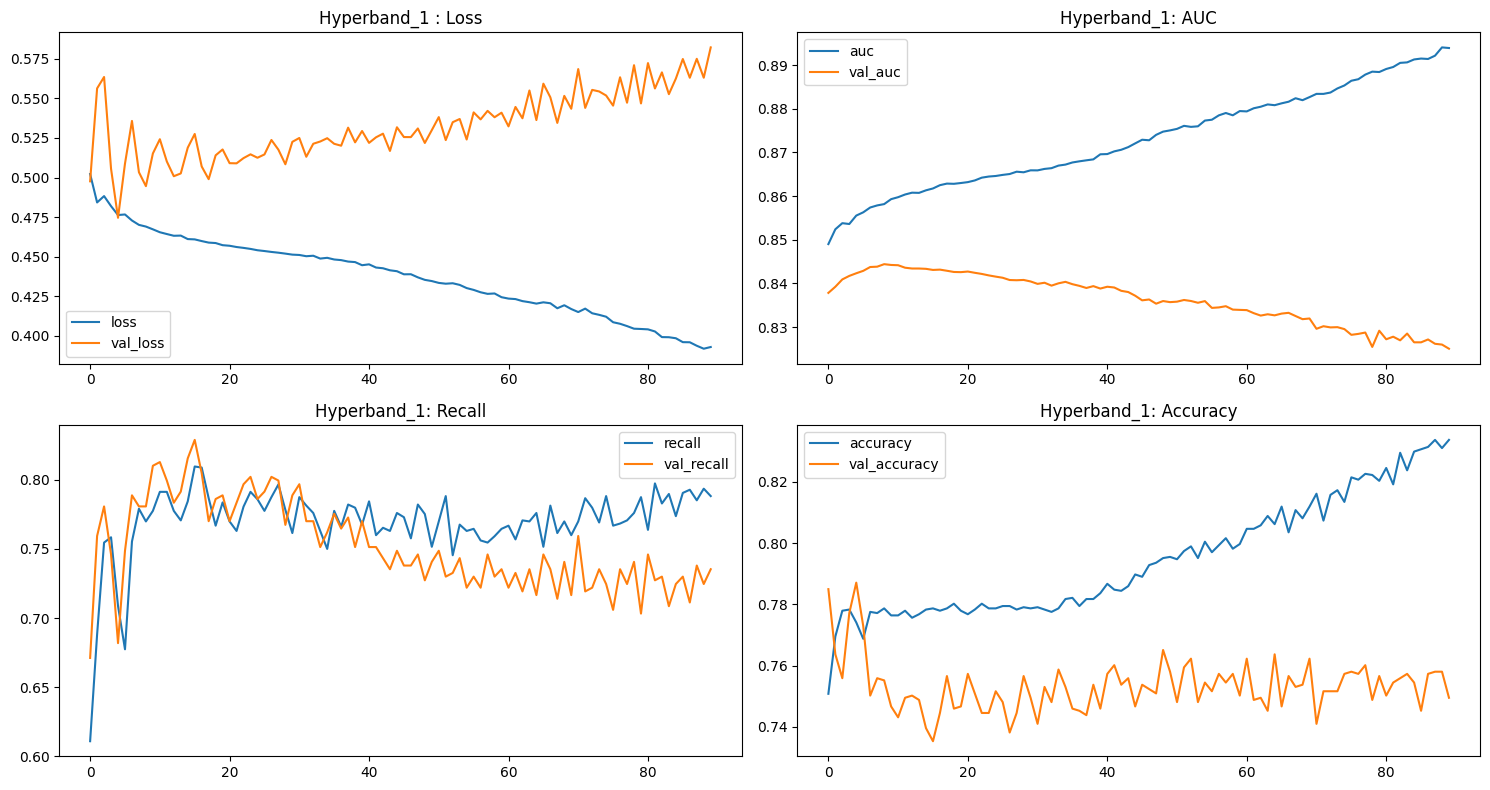

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15, 8))

prvi_model[["loss", "val_loss"]].plot.line(title='Hyperband_1 : Loss', ax=axes[0,0])

prvi_model[["auc", "val_auc"]].plot.line(title='Hyperband_1: AUC', ax=axes[0,1])

prvi_model[["recall", "val_recall"]].plot.line(title='Hyperband_1: Recall', ax=axes[1,0])

prvi_model[["accuracy", "val_accuracy"]].plot.line(title='Hyperband_1: Accuracy', ax=axes[1,1])

plt.tight_layout()
plt.show()

In [ ]:
hyperband_model = best_model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.5607 - accuracy: 0.7660 - auc: 0.8256 - recall: 0.7326


In [ ]:
best_model2 = tf.keras.callbacks.ModelCheckpoint('best_model_hyperband_2.h5',
                                                     monitor='val_accuracy',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')

In [ ]:
hyperband_alg2 = best_model_2.fit(
    X_train_undersampling, y_train_undersampling, epochs=najbolji_2.get('epochs'),
    validation_data=(X_val, y_val), batch_size=najbolji_2.get('batch_size'),
    callbacks=[best_model2]
).history

Epoch 1/90
1/3 [=========>....................] - ETA: 2s - loss: 0.4937 - accuracy: 0.7500 - auc: 0.8552 - recall: 0.6189
Epoch 1: val_accuracy improved from -inf to 0.76437, saving model to best_model_hyperband_2.h5
3/3 [==============================] - 2s 207ms/step - loss: 0.4752 - accuracy: 0.7649 - auc: 0.8584 - recall: 0.6743 - val_loss: 0.5026 - val_accuracy: 0.7644 - val_auc: 0.8441 - val_recall: 0.7674
Epoch 2/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4785 - accuracy: 0.7617 - auc: 0.8493 - recall: 0.7295
Epoch 2: val_accuracy did not improve from 0.76437
3/3 [==============================] - 0s 24ms/step - loss: 0.4605 - accuracy: 0.7768 - auc: 0.8630 - recall: 0.7469 - val_loss: 0.5143 - val_accuracy: 0.7622 - val_auc: 0.8443 - val_recall: 0.7834
Epoch 3/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4637 - accuracy: 0.7852 - auc: 0.8599 - recall: 0.7765
Epoch 3: val_accuracy improved from 0.76437 to 0.77218, saving model to best_model_hyper

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 53ms/step - loss: 0.4588 - accuracy: 0.7806 - auc: 0.8640 - recall: 0.7615 - val_loss: 0.4876 - val_accuracy: 0.7722 - val_auc: 0.8448 - val_recall: 0.7620
Epoch 4/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4645 - accuracy: 0.7715 - auc: 0.8587 - recall: 0.7282
Epoch 4: val_accuracy did not improve from 0.77218
3/3 [==============================] - 0s 28ms/step - loss: 0.4574 - accuracy: 0.7760 - auc: 0.8648 - recall: 0.7446 - val_loss: 0.5093 - val_accuracy: 0.7608 - val_auc: 0.8450 - val_recall: 0.7674
Epoch 5/90
1/3 [=========>....................] - ETA: 0s - loss: 0.4420 - accuracy: 0.7715 - auc: 0.8724 - recall: 0.7307
Epoch 5: val_accuracy did not improve from 0.77218
3/3 [==============================] - 0s 26ms/step - loss: 0.4558 - accuracy: 0.7810 - auc: 0.8659 - recall: 0.7485 - val_loss: 0.5283 - val_accuracy: 0.7601 - val_auc: 0.8452 - val_recall: 0.8021
Epoch 6/90
1/3 [=========>....................] - ETA: 0s 

In [ ]:
drugi_model = pd.DataFrame(hyperband_alg2)
drugi_model

,loss,accuracy,auc,recall,val_loss,val_accuracy,val_auc,val_recall
0,0.475162,0.764908,0.858393,0.674312,0.502604,0.764372,0.844133,0.767380
1,0.460453,0.776758,0.863000,0.746942,0.514290,0.762243,0.844309,0.783422
2,0.458797,0.780581,0.863963,0.761468,0.487595,0.772179,0.844838,0.762032
3,0.457357,0.775994,0.864771,0.744648,0.509283,0.760823,0.845017,0.767380
4,0.455791,0.780963,0.865935,0.748471,0.528250,0.760114,0.845161,0.802139
...,...,...,...,...,...,...,...,...
85,0.282386,0.875000,0.951091,0.883792,0.798168,0.693400,0.802142,0.812834
86,0.331474,0.845948,0.929670,0.856269,0.645774,0.743080,0.808373,0.703209
87,0.293288,0.866973,0.946955,0.860856,0.808979,0.694109,0.806174,0.820856
88,0.283075,0.869266,0.949181,0.906728,0.618740,0.718950,0.783062,0.609626


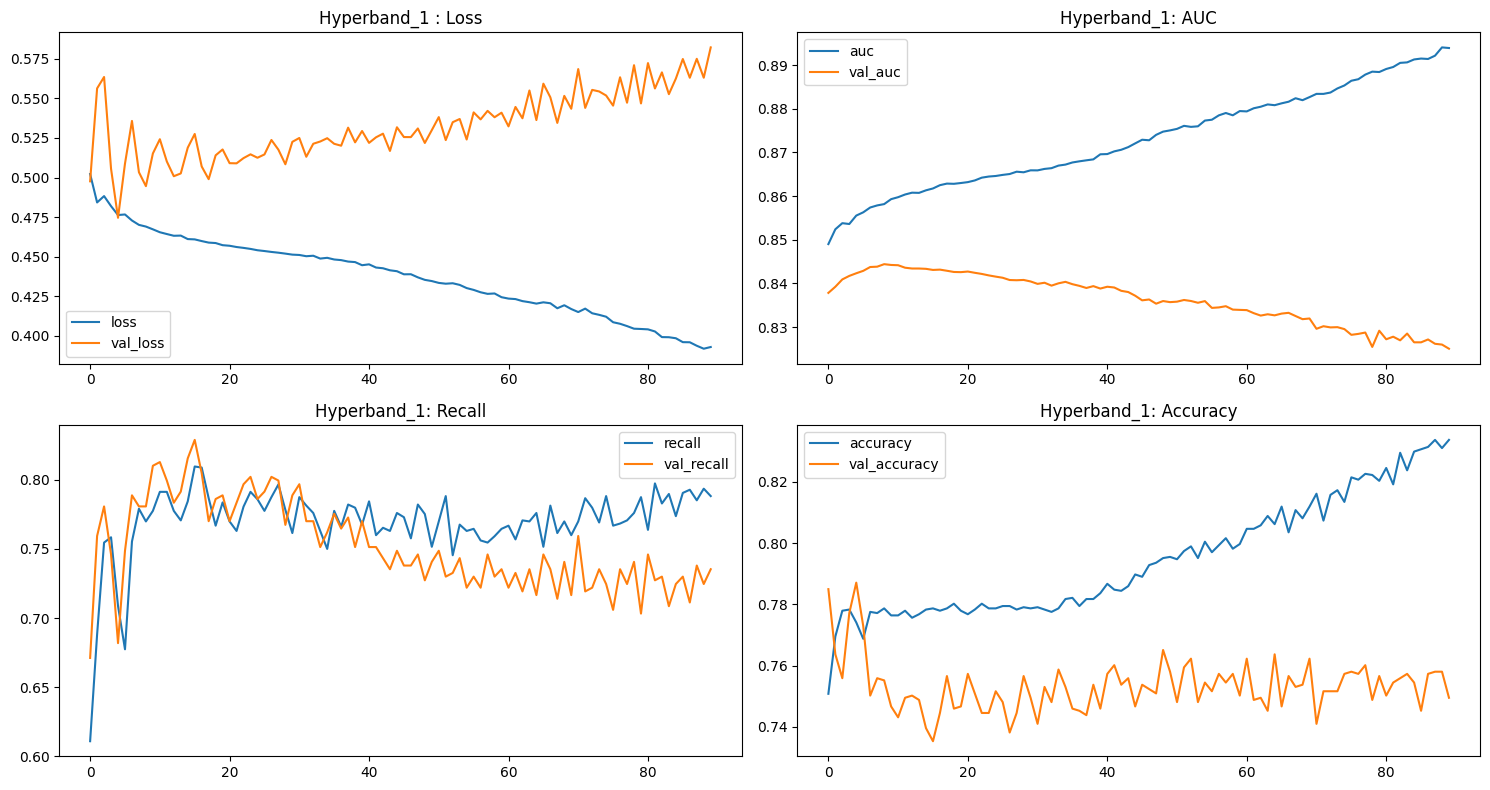

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (15, 8))

prvi_model[["loss", "val_loss"]].plot.line(title='Hyperband_1 : Loss', ax=axes[0,0])

prvi_model[["auc", "val_auc"]].plot.line(title='Hyperband_1: AUC', ax=axes[0,1])

prvi_model[["recall", "val_recall"]].plot.line(title='Hyperband_1: Recall', ax=axes[1,0])

prvi_model[["accuracy", "val_accuracy"]].plot.line(title='Hyperband_1: Accuracy', ax=axes[1,1])

plt.tight_layout()
plt.show()

In [ ]:
hyperband_model2 = best_model_2.evaluate(X_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.7249 - accuracy: 0.7362 - auc: 0.8102 - recall: 0.7968


In [ ]:
predict_hyperband = best_model.predict(X_test)
hyperband_results = np.where(predict_hyperband > 0.5, 1, 0)

23/23 [==============================] - 0s 1ms/step


In [ ]:
predict_hyperband_2 = best_model_2.predict(X_test)
hyperband_results_2 = np.where(predict_hyperband_2 > 0.5, 1, 0)

23/23 [==============================] - 0s 2ms/step


##Metrike

In [ ]:
print(f"Classification Report:\n{classification_report(y_test, hyperband_results,digits=4)}")

final_results = tf.keras.metrics.AUC()
final_results.update_state(y_test, predict_hyperband)
print(f"\nAUC: {(final_results.result()*100):.2f}%")

Classification Report:
              precision    recall  f1-score   support

           0     0.8896    0.7780    0.8301       518
           1     0.5437    0.7326    0.6241       187

    accuracy                         0.7660       705
   macro avg     0.7166    0.7553    0.7271       705
weighted avg     0.7979    0.7660    0.7755       705


AUC: 82.56%


In [ ]:
print(f"Classification Report:\n{classification_report(y_test, hyperband_results_2,digits=4)}")

final_results = tf.keras.metrics.AUC()
final_results.update_state(y_test, predict_hyperband_2)
print(f"\nAUC: {(final_results.result()*100):.2f}%")

Classification Report:
              precision    recall  f1-score   support

           0     0.9069    0.7143    0.7991       518
           1     0.5017    0.7968    0.6157       187

    accuracy                         0.7362       705
   macro avg     0.7043    0.7555    0.7074       705
weighted avg     0.7994    0.7362    0.7505       705


AUC: 81.02%


Usporedbom rezultata metrika između ova dva slučaja odabira hiperparametara sa algoritmom Hyperband može se ustvrditi da prva kombinacija hiperparametara bolje klasificira konačne kategorije. Što se tiče rezultata za metriku 'F1 - score' prvi model daje bolje rezultate za obje klase. Za metriku AUC i Accuracy bolji je model iz prvog slučaja.

Matrica konfuzije za prvi slučaj: 


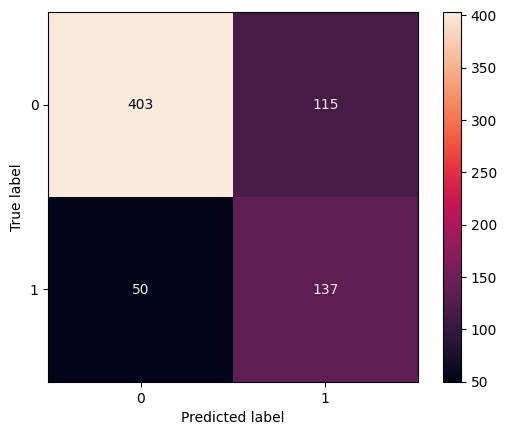

In [ ]:
print("Matrica konfuzije za prvi slučaj: ")
matrica_konfuzije = metrics.confusion_matrix(y_test, hyperband_results)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrica_konfuzije)
cm_display.plot(cmap='rocket')
plt.show()

Matrica konfuzije za drugi slučaj: 


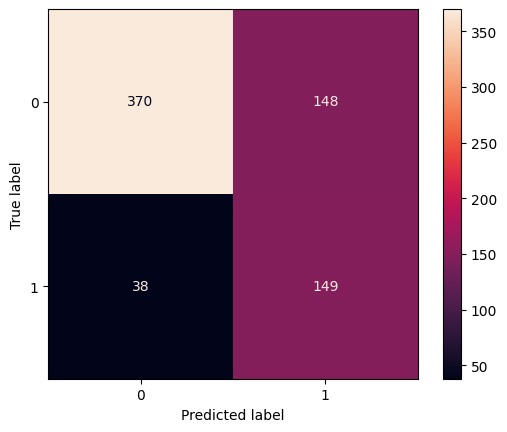

In [ ]:
print("Matrica konfuzije za drugi slučaj: ")
matrica_konfuzije_2 = metrics.confusion_matrix(y_test, hyperband_results_2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrica_konfuzije_2)
cm_display.plot(cmap='rocket')
plt.show()

Prema matrici konfuzije može se uočiti da je model iz prvog slučaja bolji od modela iz drugog slučaja.

jedina razlika između ova dva slučaja u kojima je korišten Hyperband algoritam je u parametru 'factor':
* S većom vrijednosti factor parametra Hyperband algoritam više kombinacija odbaciva u svakoj iteraciji što uvelike utječe na konačan rezultat pretrage.
* Za parametar factor treba pronaći optimalni omjer zbog toga što prevelikim odbacivanjem modela u svakoj iteraciji može se dogoditi da značajne kombinacije se uklone čak i ako se u početnim fazama testiranja nisu pokazali kao najbolji.

### Hiperparametri koje je odabrao Hyperband algoritam
| Hiperparametar | Hyperband_1 | Hyperband_2 |
|----------|----------|----------|
| Neuroni u prvom sloju | 27 | 75 |
| Neuroni u drugom sloju | 35 | 17 |
| Neuroni u trećem sloju | 7 | 15 |
| Aktivacijska funkcija (1) | Sigmoid | ReLU |
| Aktivacijska funkcija (2) | Sigmoid | Sigmoid |
| Optimizator | Adam | RMS Prop |
| Stopa učenja | 0.1 | 0.01 |
| Broj epoha | 90 | 90 |
| Veličina serije | 1024 | 1024 |